# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.stats import norm
from tqdm.notebook import tqdm

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 52613,
  "iopub_port": 41493,
  "stdin_port": 39057,
  "control_port": 56551,
  "hb_port": 37123,
  "ip": "127.0.0.1",
  "key": "9bef3229-ea63d6381607a0da23d81915",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3ee21c65-f2b0-43ce-b280-aa3b136eb703.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.05)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# initialize category veto list
fit_data.veto_list = [
    # baseline
    #'ee_cat_gt2_eq1_b', 'ee_cat_gt2_gt2_b', 
    #'mumu_cat_gt2_eq1_b', 'mumu_cat_gt2_gt2_b', 
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'e4j_cat_gt4_eq1', 'e4j_cat_gt4_gt2',
    #'mu4j_cat_gt4_eq1', 'mu4j_cat_gt4_gt2', 
    'e4j_cat_eq3_gt2', 'mu4j_cat_eq3_gt2',
    
    # e/mu DY CR
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', 'emu_cat_eq1_eq1_a', 
    
    # e+mu WW
    'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]

In [4]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [5, 5, 5]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [5]:
# initialize fit data
fobj = partial(fit_data.objective,
               data = None,
               do_bb_lite = True,
               no_shape = True,
               lu_test = 2
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = None,
                   do_bb_lite = True,
                   no_shape = True,
                   lu_test = 2
                  )


In [6]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-3, 
                   disp=True
                  )

results = []
cost = []
sv_accept = []
mask = fit_data._pmask
pinit = params_pre[mask]
for sv in tqdm(scan_vals):
    
    # randomize n.p.
    mask[:4] = False
    np_random = params_pre[mask] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    fit_data._pval_init[mask] = np_random
    #sv[mask] = np_random
    mask[:4] = True
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]
        #sample[category] = [val, val]
    
    fobj.keywords['data'] = sample
    fobj_jac.keywords['data'] = sample

    # carry out minimization
    result = minimize(fobj, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fobj_jac,
                      #args    = (sample)
                     )
    print(result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(' scan vals: ', sv[:4])
    print(' fit vals:', result.x[:4], end='\n\n')

    results.append(result.x)
    cost.append(result.fun)
    sv_accept.append(sv[mask])
    

         Current function value: 7.622969
         Iterations: 75
         Function evaluations: 197
         Gradient evaluations: 184
False 779.3816049644438 799.0553284301585 7.622968929840439
 scan vals:  [0.104 0.104 0.104 0.688]
 fit vals: [0.1041 0.1033 0.1073 0.6852]

         Current function value: 4.997325
         Iterations: 72
         Function evaluations: 111
         Gradient evaluations: 101
False 769.5247508791987 747.7103209209962 4.997325259139715
 scan vals:  [0.104  0.104  0.1075 0.6845]
 fit vals: [0.1049 0.1051 0.1033 0.6866]

         Current function value: 6.169313
         Iterations: 69
         Function evaluations: 134
         Gradient evaluations: 125
False 773.6124285325807 732.9960148593491 6.169312844955434
 scan vals:  [0.104 0.104 0.111 0.681]
 fit vals: [0.105  0.1046 0.1145 0.6759]

         Current function value: 9.947100
         Iterations: 66
         Function evaluations: 133
         Gradient evaluations: 122
False 772.7898170309687 735.6

         Current function value: 8.658877
         Iterations: 72
         Function evaluations: 151
         Gradient evaluations: 140
False 772.5820007896139 6156.652879394534 8.658876891993138
 scan vals:  [0.104 0.118 0.118 0.66 ]
 fit vals: [0.1034 0.1198 0.1198 0.657 ]

         Current function value: 6.854667
         Iterations: 64
         Function evaluations: 127
         Gradient evaluations: 117
False 778.2961466323562 613.106000160003 6.854667419053122
 scan vals:  [0.1075 0.104  0.104  0.6845]
 fit vals: [0.1081 0.1049 0.1094 0.6776]

         Current function value: 4.282794
         Iterations: 58
         Function evaluations: 134
         Gradient evaluations: 123
False 767.5453949894217 579.773902818374 4.282794382911708
 scan vals:  [0.1075 0.104  0.1075 0.681 ]
 fit vals: [0.1063 0.1038 0.1116 0.6783]

         Current function value: 3.569473
         Iterations: 60
         Function evaluations: 155
         Gradient evaluations: 143
False 784.7834682784088 597

         Current function value: 8.369116
         Iterations: 65
         Function evaluations: 123
         Gradient evaluations: 112
False 770.1949172481824 5921.05411878275 8.369116207193132
 scan vals:  [0.1075 0.118  0.1145 0.66  ]
 fit vals: [0.1089 0.1182 0.1129 0.66  ]

         Current function value: 4.589412
         Iterations: 79
         Function evaluations: 207
         Gradient evaluations: 193
False 778.3824774441696 6069.916482088804 4.589411970690696
 scan vals:  [0.1075 0.118  0.118  0.6565]
 fit vals: [0.1079 0.1182 0.1112 0.6627]

         Current function value: 4.895140
         Iterations: 58
         Function evaluations: 154
         Gradient evaluations: 142
False 781.1055939261871 1019.9201081418936 4.895140332511585
 scan vals:  [0.111 0.104 0.104 0.681]
 fit vals: [0.1111 0.103  0.1    0.6859]

Optimization terminated successfully.
         Current function value: 12.663046
         Iterations: 55
         Function evaluations: 74
         Gradient eval

         Current function value: 6.817752
         Iterations: 83
         Function evaluations: 241
         Gradient evaluations: 228
False 785.2517738591374 6272.082584732163 6.817752222802876
 scan vals:  [0.111 0.118 0.111 0.66 ]
 fit vals: [0.1113 0.1167 0.1111 0.6609]

         Current function value: 4.475471
         Iterations: 81
         Function evaluations: 264
         Gradient evaluations: 250
False 787.212061475347 6410.961161721496 4.47547095835293
 scan vals:  [0.111  0.118  0.1145 0.6565]
 fit vals: [0.1102 0.1176 0.1095 0.6627]

         Current function value: 4.777001
         Iterations: 76
         Function evaluations: 152
         Gradient evaluations: 142
False 775.506237380071 6558.533936227357 4.7770007057907575
 scan vals:  [0.111 0.118 0.118 0.653]
 fit vals: [0.1094 0.1166 0.1194 0.6546]

         Current function value: 7.890844
         Iterations: 49
         Function evaluations: 132
         Gradient evaluations: 120
False 766.5225716182731 1970.77

         Current function value: 10.705428
         Iterations: 76
         Function evaluations: 168
         Gradient evaluations: 157
False 787.5404312835449 7158.012325988161 10.705427759948043
 scan vals:  [0.1145 0.118  0.1075 0.66  ]
 fit vals: [0.1125 0.1176 0.1057 0.6643]

         Current function value: 8.162655
         Iterations: 77
         Function evaluations: 156
         Gradient evaluations: 145
False 782.8256773676857 7284.215548950204 8.162654742120996
 scan vals:  [0.1145 0.118  0.111  0.6565]
 fit vals: [0.1138 0.1186 0.1088 0.6588]

         Current function value: 2.357065
         Iterations: 75
         Function evaluations: 137
         Gradient evaluations: 127
False 768.2655770315297 7423.372635926561 2.357064885788328
 scan vals:  [0.1145 0.118  0.1145 0.653 ]
 fit vals: [0.1149 0.1175 0.1103 0.6573]

         Current function value: 5.861962
         Iterations: 80
         Function evaluations: 140
         Gradient evaluations: 129
False 782.148936295

         Current function value: 6.388587
         Iterations: 86
         Function evaluations: 174
         Gradient evaluations: 162
False 790.6713461969737 8573.190314320796 6.388587453254258
 scan vals:  [0.118 0.118 0.104 0.66 ]
 fit vals: [0.1193 0.1169 0.1095 0.6544]

         Current function value: 4.979188
         Iterations: 91
         Function evaluations: 189
         Gradient evaluations: 177
False 773.2268306253212 8678.47462428581 4.979187804663389
 scan vals:  [0.118  0.118  0.1075 0.6565]
 fit vals: [0.1159 0.1178 0.1008 0.6655]

         Current function value: 4.920900
         Iterations: 92
         Function evaluations: 126
         Gradient evaluations: 116
False 774.2107533769813 8825.466756616417 4.920900316864577
 scan vals:  [0.118 0.118 0.111 0.653]
 fit vals: [0.1174 0.1181 0.1186 0.6459]

         Current function value: 6.804083
         Iterations: 88
         Function evaluations: 159
         Gradient evaluations: 147
False 783.8697009552853 9004.0

In [7]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost = np.array(cost)

diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= params['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


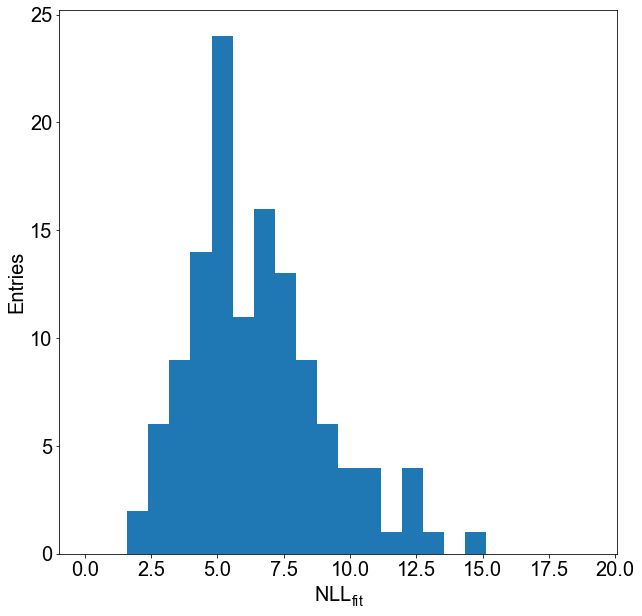

In [8]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

cost = cost[cost<600]
cost_mean, cost_err = cost.mean(), cost.std()
ax.hist(cost, bins=np.linspace(np.max([0, cost_mean - 5*cost_err]), cost_mean + 5*cost_err, 25), histtype='stepfilled')
ax.set_xlabel(r'$NLL_{fit}$')
ax.set_ylabel('Entries')

plt.show()

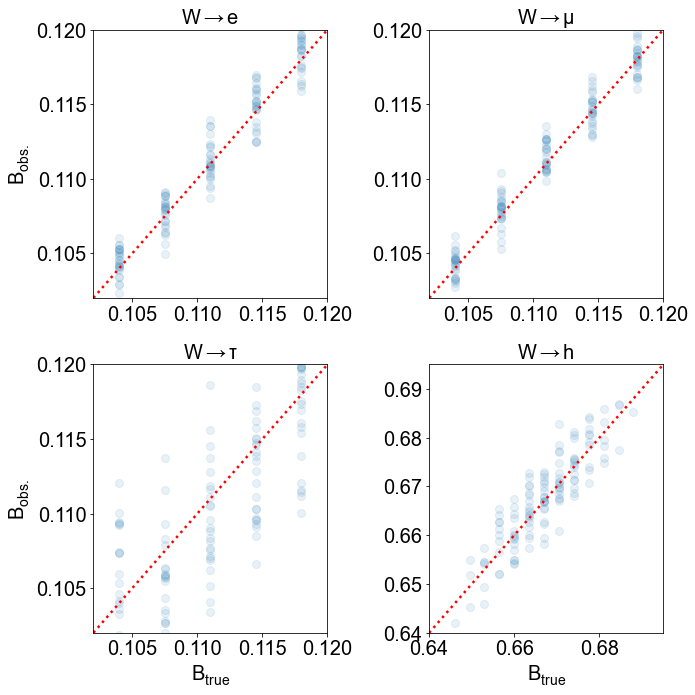

In [9]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.64, 0.72], [0.64, 0.72], 'r:')
ax.set_xlim(0.64, 0.695)
ax.set_ylim(0.64, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

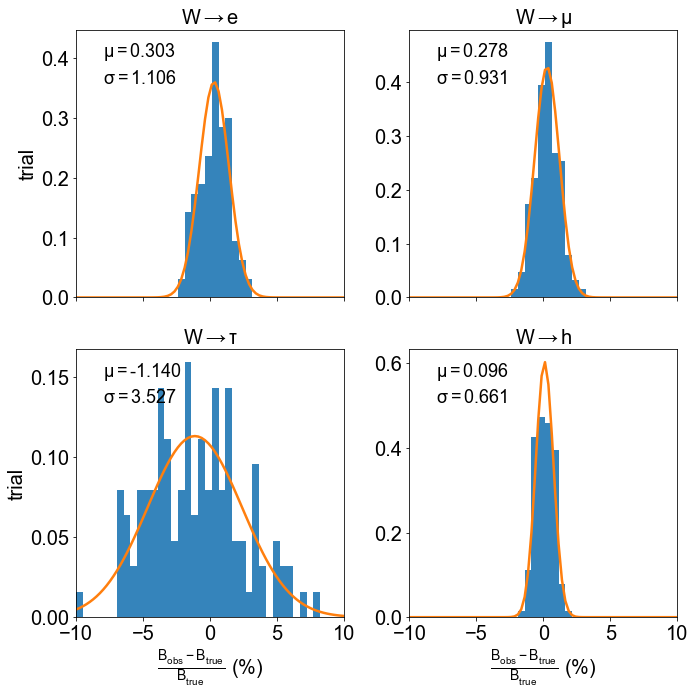

In [10]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=True, sharey=False)
bins = np.linspace(-10, 10, 80)

ax = axes[0][0]
dbeta = 100*(beta_obs[:,0] - beta_val[:,0])/beta_val[:,0]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
dbeta = 100*(beta_obs[:,1] - beta_val[:,1])/beta_val[:,1]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
dbeta = 100*(beta_obs[:,2] - beta_val[:,2])/beta_val[:,2]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
dbeta = 100*(beta_obs[:,3] - beta_val[:,3])/beta_val[:,3]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow h$', size=20)

ax.set_xlim(-10, 10)
ax.set_ylim(0., None)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_bias.pdf')
plt.show()

In [11]:
#plotting the results
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('data/model_parameters_asimov.csv').query('active == True')
df_pulls.loc[:3, 'ratio'] *= 100
df_pulls = df_pulls.set_index('name')
pull_post = (df_pulls['val_fit'] - df_pulls['val_init'])/df_pulls['err_init']

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.errorbar(xticks[0]+1,  pull_post.values, df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params[mask].label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_xlim(4.5, nparams+0.5)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()